In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import pandas_ta as ta
import quantstats as qs
qs.extend_pandas()

import numpy as np
import datetime
from tqdm import tqdm
from matplotlib import pyplot as plt
%matplotlib inline

params = {#'font.size' : 16,
          'figure.facecolor': 'w'}
plt.rcParams.update(params)
#plt.style.use('dark_background')

## Data Preparation

In [2]:
# Data Directory
data_dir = '/workspace/202205_idx-trading/_data/'
lq45_dir = '/workspace/202205_idx-trading/_data/20220525_lq45/'
lq45_index_file = data_dir + '20220525_lq45_index.csv'
lq45_list = '20220525_lq45-list.txt'
issi_list = '20220525_issi-list.txt'

# Prepare Stock Tickers
with open(data_dir + lq45_list, "r") as f:
    lq45_tickers = f.read().split('\n')

with open(data_dir + issi_list, "r") as f:
    issi_tickers = f.read().split('\n')

## (Alternatively) Select only Halal lq45 tickers using issi tickers
halal_lq45_tickers = [f for f in lq45_tickers if f in issi_tickers]

## Prepare active tickers for international codes
active_tickers_international = [f + '.JK' for f in lq45_tickers]
halal_active_tickers_international = [f + '.JK' for f in halal_lq45_tickers]

In [3]:
# Read downloaded stock Adjusted Close Price data
lq45_df_dict = {}
for ticker in tqdm(active_tickers_international):
    lq45_df_dict[ticker] = pd.read_csv(lq45_dir + ticker + '.csv')
    
lq45_index_data = pd.read_csv(lq45_index_file)

100%|██████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 137.10it/s]


In [4]:
# Do Some basic data Operations (Fill NaN and calculate Returns)
for ticker in tqdm(active_tickers_international):
    # Fill NaN values with the earliest data
    lq45_df_dict[ticker].fillna(method='bfill', axis=0, inplace=True)
    
    # Drop earliest NaN Value without Returns
    lq45_df_dict[ticker].dropna(inplace=True)

# Do the same for lq45 index data
lq45_index_data.fillna(method='bfill', axis=0, inplace=True)
lq45_index_data.dropna(inplace=True)

100%|██████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 399.28it/s]


In [5]:
# Select Data Range
lq45_index_data['Date'] = pd.to_datetime(lq45_index_data['Date'])
lq45_index_data = lq45_index_data[lq45_index_data['Date'] >= '1998-01-01']
lq45_index_data = lq45_index_data.reset_index(drop=True)

## Strategy

### Baseline Strategy

Buy and Hold LQ45

In [6]:
# Simple buy and hold strategy
lq45_index_buy_hold = lq45_index_data.copy()

lq45_index_buy_hold['signal'] = ''
lq45_index_buy_hold['close'] = lq45_index_buy_hold['Adj Close']
lq45_index_buy_hold = lq45_index_buy_hold[['Date', 'close', 'signal']]
lq45_index_buy_hold = lq45_index_buy_hold.reset_index(drop=True)

lq45_index_buy_hold['signal'][0] = 'buy'
lq45_index_buy_hold['signal'][len(lq45_index_buy_hold)-1] = 'sell'

### Trading Strategy
Source: https://mikeharrisny.medium.com/efficient-market-hypothesis-the-biggest-farce-in-history-of-finance-and-economics-3f69c8e0de45

Long only, buy signal is closed on sell signal.

20220526 Modification: Added stop loss for buy signal using bollinger bands

In [14]:
# Define Strategy
def strategy(df):
    # Take only the important columns
    df_proc = df
    df_proc['signal'] = ''
    df_proc['close'] = df_proc['Adj Close']
    df_proc = df_proc[['Date', 'close', 'signal']]
    
    # Generate EMA
    df_proc.ta.ema(append=True)
    df_proc.ta.bbands(append=True, std=2)
    df_proc.dropna(inplace=True)
    df_proc = df_proc.reset_index(drop=True)
    
    # Signal Rule
    buy_signal = lambda price, ema: (price > ema)
    sell_signal = lambda price, ema: (price < ema)
    
    # Generate Signals
    last_signal = ''
    last_lower_bband = np.inf
    for i in tqdm(range(0, len(df_proc))):
        if i == 0:
            df_proc['signal'][i] = ''
        
        elif last_signal == '':
            if buy_signal(df_proc['close'][i], df_proc['EMA_10'][i]):
                df_proc['signal'][i] = 'buy'
                last_signal = 'buy'
                last_lower_bband = df_proc['BBL_5_2.0'][i]
            elif sell_signal(df_proc['close'][i], df_proc['EMA_10'][i]):
                df_proc['signal'][i] = 'sell'
                last_signal = 'sell'
            else:
                df_proc['signal'][i] = ''
            
        elif last_signal == 'buy':
            if sell_signal(df_proc['close'][i], df_proc['EMA_10'][i]):
                df_proc['signal'][i] = 'sell'
                last_signal = 'sell'
                
            # Stop Loss
            # elif (df_proc['close'][i] < last_lower_bband):
            #     df_proc['signal'][i] = 'sell'
            #     last_signal = 'sell'
            #     last_lower_bband = np.inf
            else:
                df_proc['signal'][i] = ''
            
        elif last_signal == 'sell':
            if buy_signal(df_proc['close'][i], df_proc['EMA_10'][i]):
                df_proc['signal'][i] = 'buy'
                last_signal = 'buy'
            else:
                df_proc['signal'][i] = ''
    
    return df_proc

def calc_returns(df):
    '''
    Calculate returns and cumulative returns per entry on dataframe.
    Is strategy specific.
    '''
    last_signal = ''
    df['return'] = ''
    for i in range(0, len(df)):
        if last_signal == 'buy':
            df["return"][i] = (df['close'][i] / df['close'][i-1]) - 1
        elif last_signal == 'sell':
            df["return"][i] = 0
        else:
            df["return"][i] = 0
        
        if not(df["signal"][i] == ''):
            last_signal = df["signal"][i] 

    df["cum_return"] = (1 + df["return"]).cumprod()
    return df

In [15]:
# Run Strategy
lq45_index_processed = strategy(lq45_index_data)

100%|█████████████████████████████████████████████████████████████| 5925/5925 [00:01<00:00, 3107.20it/s]


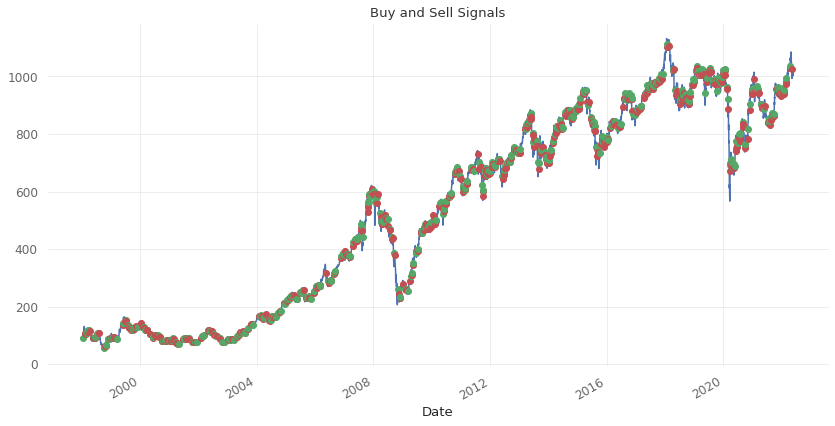

In [16]:
# Plot Buy and Sell Signals On Graph
lq45_index_processed.set_index('Date')['close'].plot(figsize=(14,7), grid=True, title='Buy and Sell Signals')

## Plot Buy and Sell Dots
for i in range(0, len(lq45_index_processed)):
    if lq45_index_processed['signal'][i] == 'buy':
        plt.plot(lq45_index_processed['Date'][i], lq45_index_processed['close'][i], 'go')
    elif lq45_index_processed['signal'][i] == 'sell':
        plt.plot(lq45_index_processed['Date'][i], lq45_index_processed['close'][i], 'ro')

## Evaluation

### Calculate Metrics for Strategy

In [17]:
# Calculate Metrics
s_df = calc_returns(lq45_index_processed)
b_df = calc_returns(lq45_index_buy_hold)

s_ret = s_df.set_index('Date')['return'].astype(float)
b_ret = b_df.set_index('Date')['return'].astype(float)

qs.reports.metrics(returns=s_ret, benchmark=b_ret, rf=0.025, mode='basic')

                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        1998-01-15  1998-01-15
End Period          2022-05-25  2022-05-25
Risk-Free Rate      2.5%        2.5%
Time in Market      59.0%       100.0%

Cumulative Return   3,087.60%   1,114.96%
CAGR﹪              15.26%      10.79%

Sharpe              0.74        0.43
Prob. Sharpe Ratio  98.6%       71.8%
Sortino             1.19        0.62
Sortino/√2          0.84        0.44
Omega               1.2         1.2

Max Drawdown        -40.59%     -66.73%
Longest DD Days     3291        1662

Gain/Pain Ratio     0.24        0.1
Gain/Pain (1M)      1.2         0.51

Payoff Ratio        1.08        1.08
Profit Factor       1.24        1.1
Common Sense Ratio  1.44        1.1
CPC Index           0.72        0.63
Tail Ratio          1.16        1.0
Outlier Win Ratio   9.72        3.8
Outlier Loss Ratio  4.21        3.46

MTD                 -5.48%      -6.99%
3M                  1.69%       3.68%

### Plot Relevant Visualizations

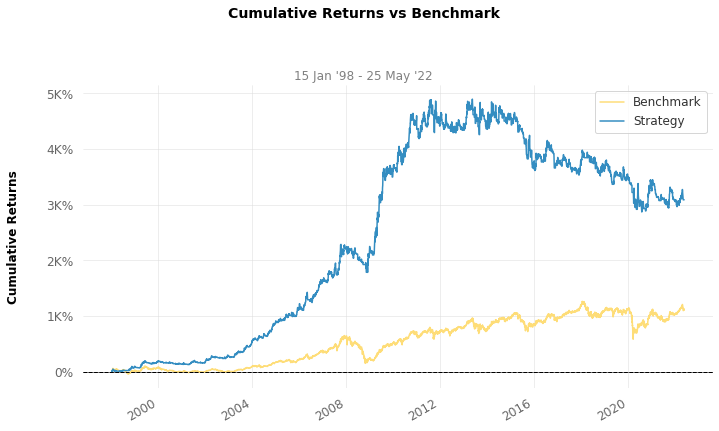

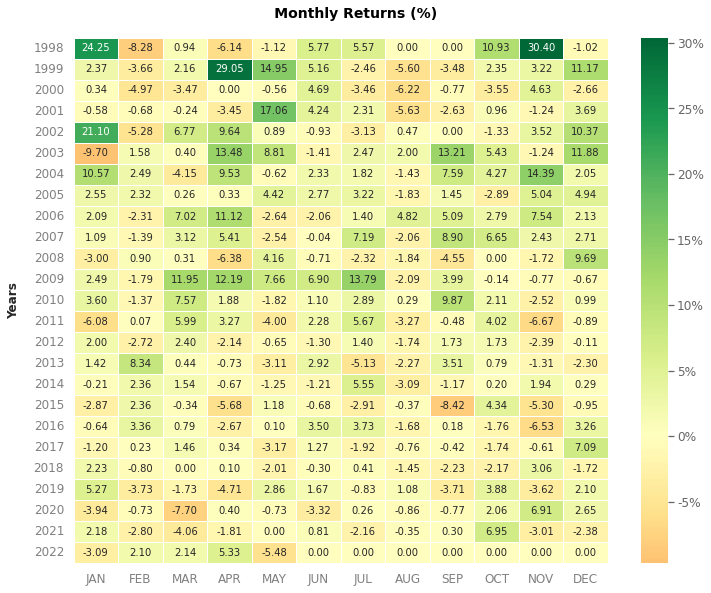

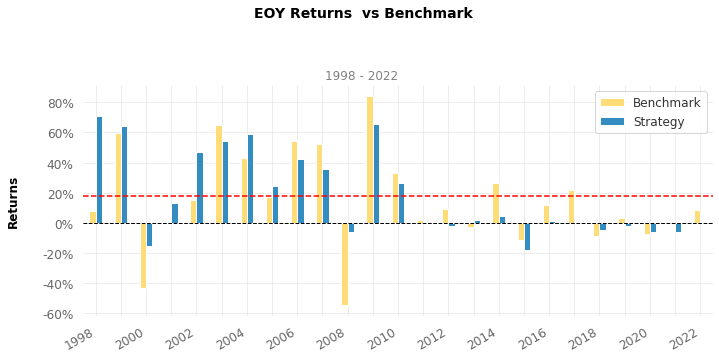

In [18]:
# Returns Visualization
qs.plots.returns(s_ret, b_ret)
qs.plots.monthly_heatmap(s_ret)
qs.plots.yearly_returns(s_ret, b_ret)

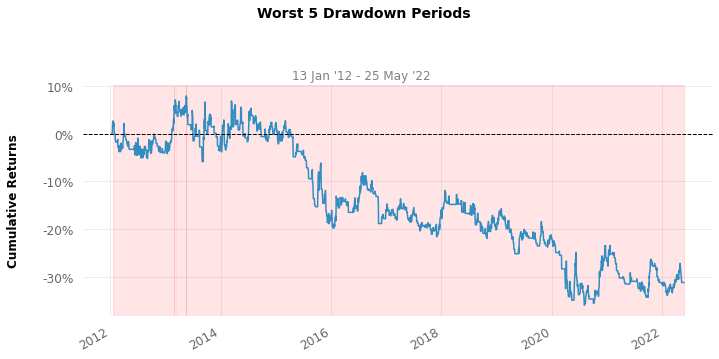

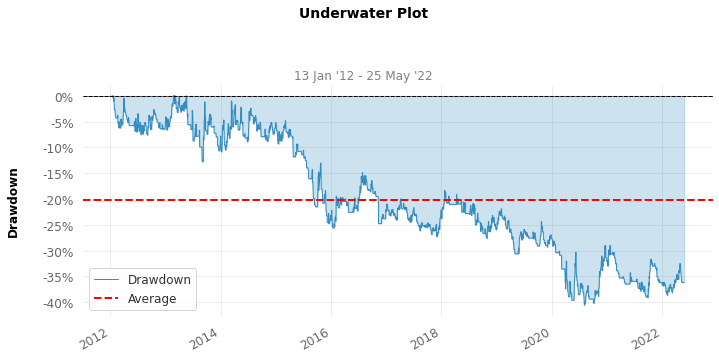

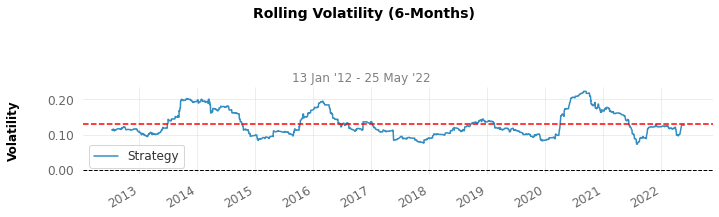

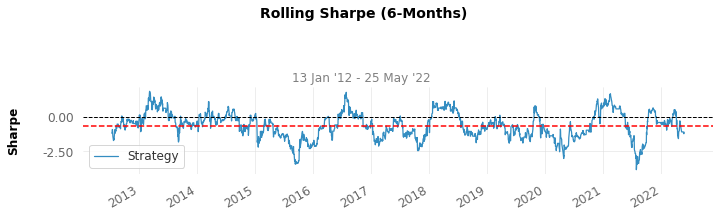

In [13]:
# Risk Visualization
qs.plots.drawdowns_periods(s_ret)
qs.plots.drawdown(s_ret)
qs.plots.rolling_volatility(s_ret)
qs.plots.rolling_sharpe(s_ret, rf=0.025)